# 4. Transferencia de Aprendizaje

## 4.1. Instalación de requerimientos

In [ ]:
# Instalación del cliente NEPTUNE
#! pip install neptune-client[fastai]

# Actualización de Matplotlib
#! pip install matplotlib --upgrade

In [2]:
# Importación de librerías

from fastai.vision.all import *
from fastai.callback.hook import *
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
import os
import shutil
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib: {}'.format(matplotlib.__version__))

from torch import optim
from functools import partial
import pandas as pd

# Importación de librerías para integración Fastai | Neptune
import neptune.new as neptune
from neptune.new.integrations.fastai import NeptuneCallback

#from nbdev.showdoc import show_doc

# Verificación de activación de GPU
print(torch.cuda.is_available())

matplotlib: 3.5.2
True


## 4.2. Definición del Conjunto de Datos

In [3]:
# Cargar el conjunto de datos en memoria
path = 'Data Folder/Plant_Disease'
files = get_image_files(path)

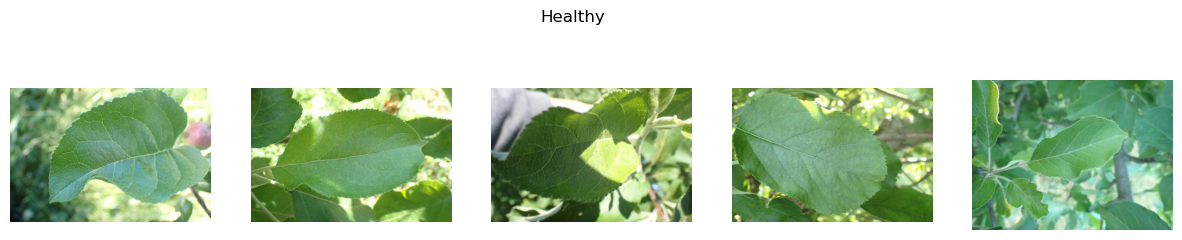

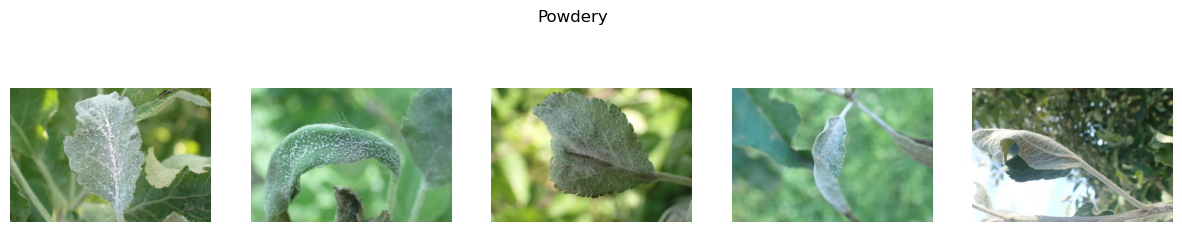

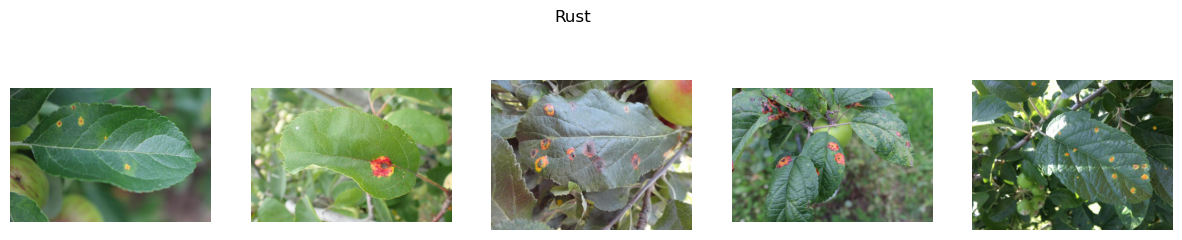

In [4]:
# Etiquetas del dataset y visualización de las muestras
labels = os.listdir(path)
dataset = {}
for label in labels:
  images = get_image_files(path, folders=label)
  dataset[label] =len(images)
  sample = [load_image(image) for image in images.shuffle()[:5]]
  show_images(sample, nrows=1, ncols=5, imsize=3, suptitle=label)

In [5]:
# Definición de funciones
# Cargar el conjunto de datos y distribuir para entrenamiento y validación
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) 
        torch.backends.cudnn.deterministic = True  
        torch.backends.cudnn.benchmark = False


# Función para la definición del dataloader
def get_dataloader(bs = 64, size=224, val=0.20, mult=1, seed = 42, cuda = False): 
  print(f"* Cargando imágenes desde {path}:")
  print(f"    Se usará {len(labels)} etiquetas: {labels}")
  print(f"    Se reservó {1-val:.0%} de los datos para el entrenamiento")
  dataloader = ImageDataLoaders.from_folder(
  path, 
  vocab=labels, 
  item_tfms=Resize(size),
  valid_pct=val, 
  batch_tfms=aug_transforms(mult=mult),
  bs = bs,
  seed = random_seed(seed_value = seed, use_cuda = cuda)
  )
  return dataloader

  # Función del aprendiz de vision
def set_vision_learner(modelo = resnet34, monitor = 'accuracy', patience = 3, **kwargs):
  return vision_learner(
      dataloader,
      arch = modelo,
      metrics=[accuracy, error_rate], 
      path='/content/',
      model_dir='models',
      cbs=[neptune_callback, 
           EarlyStoppingCallback(monitor=monitor, min_delta=0.01, patience=patience), 
           SaveModelCallback(monitor=monitor, min_delta=0.01),
           ActivationStats(with_hist=True)],
      **kwargs
       
  )

In [6]:
dataloader = get_dataloader(val=0.20)

* Cargando imágenes desde Data Folder/Plant_Disease:
    Se usará 3 etiquetas: ['Healthy', 'Powdery', 'Rust']
    Se reservó 80% de los datos para el entrenamiento


In [7]:
# Verificación
plot_labels = []
plot_train_imgs = []
plot_valid_imgs = []
for label in labels:
    num_train_imgs = len([path for path in dataloader.train_ds.items if path.parent.name == label])
    num_valid_imgs = len([path for path in dataloader.valid_ds.items if path.parent.name == label])
    plot_labels.append(label)
    plot_train_imgs.append(num_train_imgs)
    plot_valid_imgs.append(num_valid_imgs)
    print(f"* Para '{label}...'")
    print(f"   Se tiene {num_train_imgs} imágenes de entrenamiento")
    print(f"   Se tiene {num_valid_imgs} imágenes de validación")

* Para 'Healthy...'
   Se tiene 412 imágenes de entrenamiento
   Se tiene 96 imágenes de validación
* Para 'Powdery...'
   Se tiene 391 imágenes de entrenamiento
   Se tiene 89 imágenes de validación
* Para 'Rust...'
   Se tiene 375 imágenes de entrenamiento
   Se tiene 109 imágenes de validación


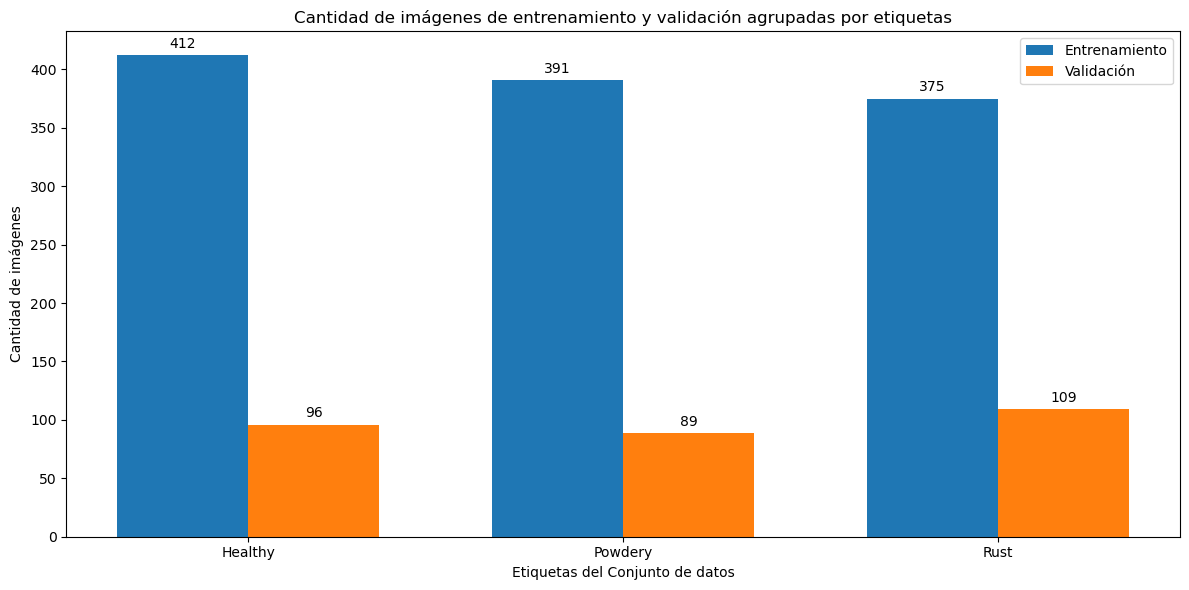

In [8]:
# Gráficos de la distribución del dataloader
x = np.arange(len(plot_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, plot_train_imgs, width, label='Entrenamiento')
rects2 = ax.bar(x + width/2, plot_valid_imgs, width, label='Validación')

ax.set_ylabel('Cantidad de imágenes')
ax.set_xlabel('Etiquetas del Conjunto de datos')
ax.set_title('Cantidad de imágenes de entrenamiento y validación agrupadas por etiquetas')
ax.set_xticks(x, plot_labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

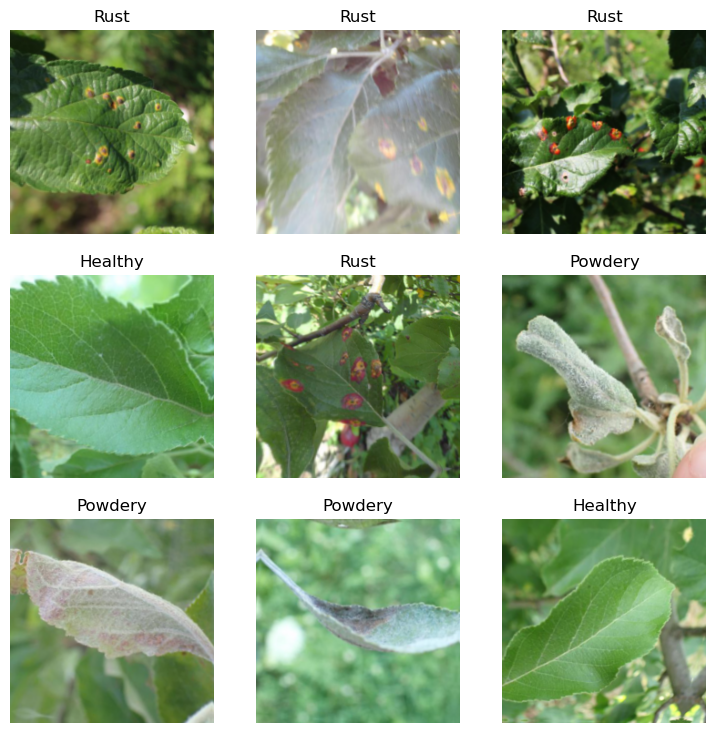

In [9]:
dataloader.show_batch()

## 4.3. Entrenamiento del Modelo

In [10]:
# Definición del Learner
learner = vision_learner(dataloader, 
                         resnet50,
                         path='/content/',
                         model_dir='models', 
                         metrics=[accuracy, error_rate], 
                         cbs=ActivationStats(with_hist=True),
                         )

In [12]:
# Resumen del Learner
learner.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

SuggestedLRs(valley=0.0010000000474974513)

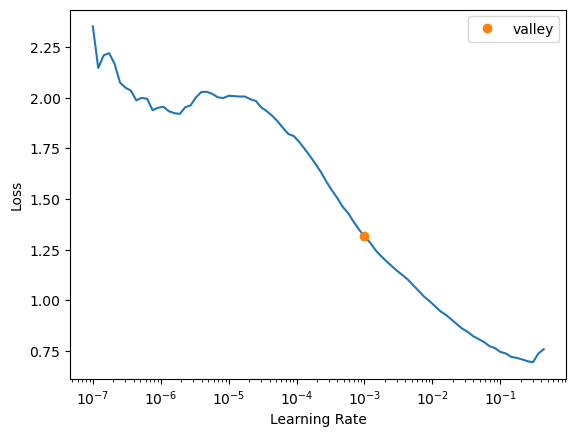

In [13]:
lr = learner.lr_find()
lr

In [14]:
learner.fine_tune(1, lr[0])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.742417,0.068101,0.986395,0.013605,03:33


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.207711,0.058749,0.986395,0.013605,03:35


In [15]:
# Función para graficar las metricas de pérdida de entrenamiento y validación, precisión y error en la validación
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

### 4.3.1. Entrenamiento y Validación

In [16]:
#Definición de Hyperparámetros
bs = 32
epochs = 20
models = [resnet34, vgg16, mobilenet_v3_large]
optimizers = [Adam, SGD]
learners = []

* Cargando imágenes desde Data Folder/Plant_Disease:
    Se usará 3 etiquetas: ['Healthy', 'Powdery', 'Rust']
    Se reservó 80% de los datos para el entrenamiento


C:\Users\regino.acosta\Anaconda3\lib\site-packages\neptune\new\internal\utils\git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


https://app.neptune.ai/racosta93/PDI/e/PDI-23
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


C:\Users\regino.acosta\Anaconda3\lib\site-packages\fastai\callback\core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.899508,0.101196,0.962585,0.037415,01:19


Better model found at epoch 0 with valid_loss value: 0.10119565576314926.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.296301,0.069884,0.976190,0.023810,01:19
1,0.209089,0.047230,0.982993,0.017007,01:19
2,0.159319,0.031875,0.989796,0.010204,01:19
3,0.128165,0.025525,0.993197,0.006803,01:19
4,0.108606,0.021652,0.993197,0.006803,01:20
5,0.071701,0.023552,0.993197,0.006803,01:21
6,0.054068,0.025946,0.993197,0.006803,01:19
7,0.045742,0.029289,0.993197,0.006803,01:20
8,0.060239,0.031753,0.993197,0.006803,01:20
9,0.048072,0.042641,0.982993,0.017007,01:20


Better model found at epoch 0 with valid_loss value: 0.06988438963890076.
Better model found at epoch 1 with valid_loss value: 0.04723023995757103.
Better model found at epoch 2 with valid_loss value: 0.03187498450279236.
Better model found at epoch 4 with valid_loss value: 0.02165154181420803.
No improvement since epoch 4: early stopping
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 12 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 12 operations (0.00% done). Please wait.
All 12 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/racosta93/PDI/e/PDI-23
https://app.neptune.ai/racosta93/PDI/e/PDI-24
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.317043,0.359303,0.877551,0.122449,01:21


Better model found at epoch 0 with valid_loss value: 0.3593026101589203.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.650061,0.293705,0.894558,0.105442,01:21
1,0.585036,0.221340,0.918367,0.081633,01:20
2,0.536644,0.171334,0.931973,0.068027,01:20
3,0.451063,0.131960,0.959184,0.040816,01:22
4,0.386536,0.090042,0.965986,0.034014,01:20
5,0.329150,0.073403,0.979592,0.020408,01:24
6,0.265273,0.060563,0.982993,0.017007,01:24
7,0.224391,0.053110,0.986395,0.013605,01:24
8,0.197983,0.052062,0.986395,0.013605,01:25
9,0.177974,0.040809,0.989796,0.010204,01:25


Better model found at epoch 0 with valid_loss value: 0.2937050759792328.
Better model found at epoch 1 with valid_loss value: 0.22133983671665192.
Better model found at epoch 2 with valid_loss value: 0.17133352160453796.
Better model found at epoch 3 with valid_loss value: 0.13195998966693878.
Better model found at epoch 4 with valid_loss value: 0.09004174172878265.
Better model found at epoch 5 with valid_loss value: 0.07340289652347565.
Better model found at epoch 6 with valid_loss value: 0.060563430190086365.
Better model found at epoch 9 with valid_loss value: 0.04080897942185402.
No improvement since epoch 9: early stopping
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 14 operations (0.00% done). Please wait.
All 14 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/racosta93/PDI/e/PDI-24
h

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.858648,0.131668,0.945578,0.054422,02:03


Better model found at epoch 0 with valid_loss value: 0.1316681206226349.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.286550,0.088397,0.965986,0.034014,02:03
1,0.232940,0.080499,0.976190,0.023810,02:01
2,0.201391,0.058906,0.986395,0.013605,02:01
3,0.171730,0.043460,0.986395,0.013605,02:01
4,0.128231,0.044483,0.989796,0.010204,02:01
5,0.092310,0.038046,0.993197,0.006803,02:04
6,0.091786,0.037227,0.996599,0.003401,02:02
7,0.092693,0.035742,0.996599,0.003401,02:03
8,0.083691,0.038305,0.996599,0.003401,02:02
9,0.067193,0.035464,0.996599,0.003401,02:03


Better model found at epoch 0 with valid_loss value: 0.0883965939283371.
Better model found at epoch 2 with valid_loss value: 0.05890611559152603.
Better model found at epoch 3 with valid_loss value: 0.04346032440662384.
Better model found at epoch 13 with valid_loss value: 0.033151160925626755.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.
All 17 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/racosta93/PDI/e/PDI-25
https://app.neptune.ai/racosta93/PDI/e/PDI-26
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.489574,0.416297,0.840136,0.159864,02:04


Better model found at epoch 0 with valid_loss value: 0.41629651188850403.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.867031,0.345757,0.870748,0.129252,02:03
1,0.826675,0.303145,0.901361,0.098639,02:02
2,0.749480,0.243554,0.925170,0.074830,02:03
3,0.676540,0.202572,0.945578,0.054422,02:02
4,0.580536,0.167623,0.959184,0.040816,02:03
5,0.538498,0.144455,0.969388,0.030612,02:03
6,0.466876,0.132412,0.962585,0.037415,02:02
7,0.395054,0.114572,0.965986,0.034014,02:02
8,0.366145,0.109202,0.969388,0.030612,02:03
9,0.366444,0.099917,0.969388,0.030612,02:02


Better model found at epoch 0 with valid_loss value: 0.34575673937797546.
Better model found at epoch 1 with valid_loss value: 0.30314531922340393.
Better model found at epoch 2 with valid_loss value: 0.24355386197566986.
Better model found at epoch 3 with valid_loss value: 0.20257151126861572.
Better model found at epoch 4 with valid_loss value: 0.16762308776378632.
Better model found at epoch 5 with valid_loss value: 0.14445507526397705.
Better model found at epoch 6 with valid_loss value: 0.1324118673801422.
Better model found at epoch 7 with valid_loss value: 0.11457187682390213.
Better model found at epoch 9 with valid_loss value: 0.0999169573187828.
Better model found at epoch 12 with valid_loss value: 0.08675049245357513.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 10 operations to synchronize with Neptune. Do not kill this process.
All 10 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptun

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.644755,0.109937,0.952381,0.047619,01:35


Better model found at epoch 0 with valid_loss value: 0.1099369153380394.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.213720,0.086738,0.972789,0.027211,01:34
1,0.192798,0.067452,0.982993,0.017007,01:33
2,0.150723,0.079498,0.976190,0.023810,01:35
3,0.130911,0.078560,0.976190,0.023810,01:34
4,0.110354,0.058273,0.979592,0.020408,01:34
5,0.087547,0.058396,0.986395,0.013605,01:34
6,0.073822,0.072065,0.972789,0.027211,01:33
7,0.077843,0.077179,0.965986,0.034014,01:33
8,0.085928,0.051326,0.989796,0.010204,01:34
9,0.063637,0.037015,0.989796,0.010204,01:33


Better model found at epoch 0 with valid_loss value: 0.0867377370595932.
Better model found at epoch 1 with valid_loss value: 0.06745235621929169.
Better model found at epoch 8 with valid_loss value: 0.05132574588060379.
Better model found at epoch 9 with valid_loss value: 0.037014737725257874.
No improvement since epoch 9: early stopping
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 12 operations to synchronize with Neptune. Do not kill this process.
All 12 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/racosta93/PDI/e/PDI-27
https://app.neptune.ai/racosta93/PDI/e/PDI-28
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.133487,0.235444,0.918367,0.081633,01:36


Better model found at epoch 0 with valid_loss value: 0.23544441163539886.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.451483,0.158872,0.952381,0.047619,01:35
1,0.443468,0.132525,0.965986,0.034014,01:35
2,0.398658,0.129044,0.959184,0.040816,01:35
3,0.349918,0.114299,0.965986,0.034014,01:35
4,0.323254,0.100348,0.969388,0.030612,01:35
5,0.284495,0.090190,0.972789,0.027211,01:36
6,0.253547,0.085651,0.972789,0.027211,01:36
7,0.225067,0.083385,0.969388,0.030612,01:34
8,0.230185,0.081740,0.969388,0.030612,01:36
9,0.201034,0.079317,0.969388,0.030612,01:35


Better model found at epoch 0 with valid_loss value: 0.1588723510503769.
Better model found at epoch 1 with valid_loss value: 0.13252465426921844.
Better model found at epoch 3 with valid_loss value: 0.11429879814386368.
Better model found at epoch 4 with valid_loss value: 0.10034774988889694.
Better model found at epoch 5 with valid_loss value: 0.09018956124782562.
Better model found at epoch 9 with valid_loss value: 0.07931726425886154.
No improvement since epoch 9: early stopping
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 12 operations to synchronize with Neptune. Do not kill this process.
All 12 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/racosta93/PDI/e/PDI-28


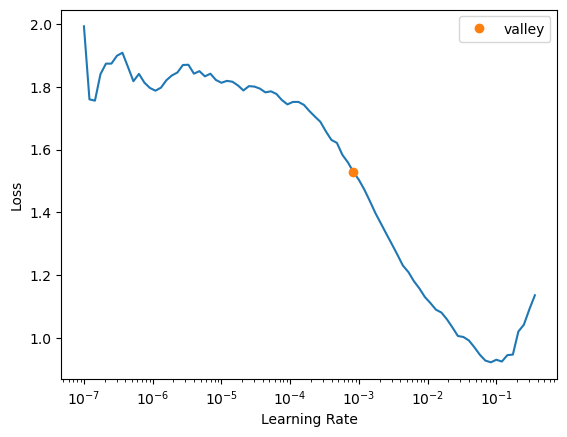

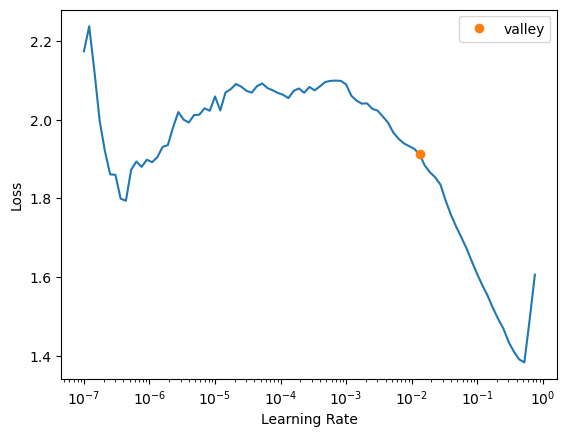

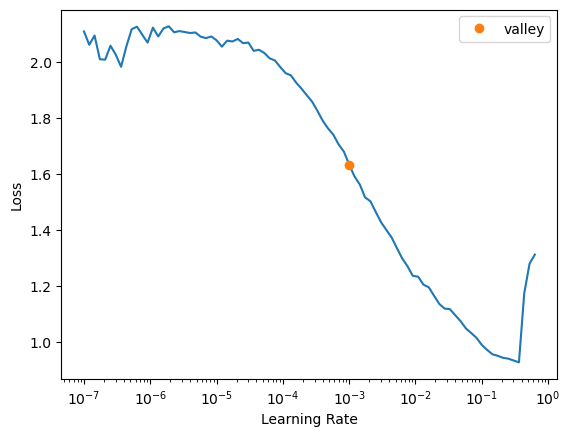

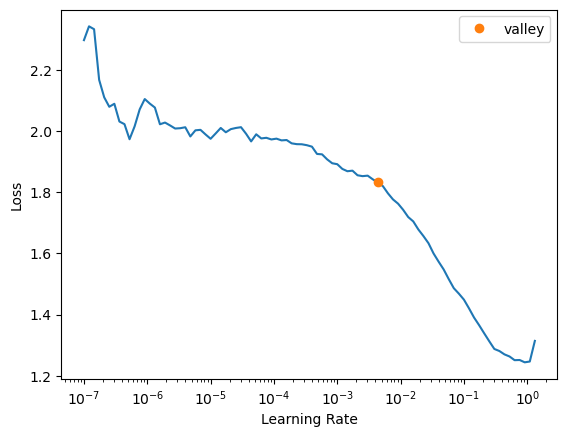

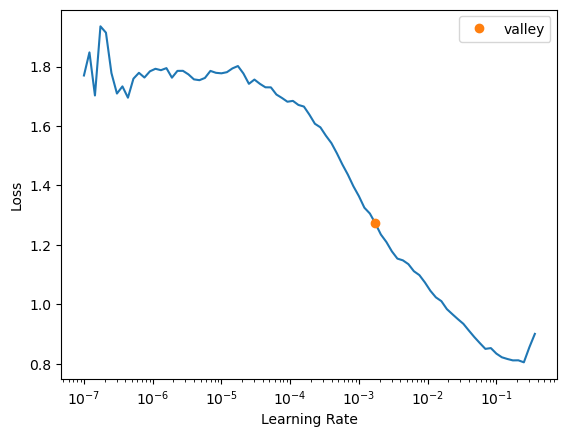

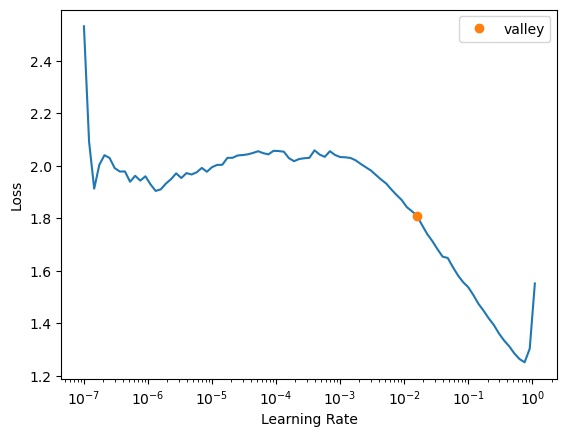

In [18]:
# Entrenando del modelo y registrando en Neptune
dataloader = get_dataloader(bs = bs)
for model in models: 
    for opt in optimizers:
        run = neptune.init_run(
            project="racosta93/PDI",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMDYyZjBhNS0zZjZhLTRjODEtYTJlMi00Yzk3ZDQ1NDFiM2IifQ==",)
        neptune_callback = NeptuneCallback(run=run)
        learner_opt = set_vision_learner(modelo = model, monitor='valid_loss', patience = 10, opt_func= opt)
        lr = learner_opt.lr_find()
        learner_opt.summary()
        learner_opt.fine_tune(epochs, lr[0])
        learner_opt.export(f' /Documents/Transfer_Learning/models/model_{str(model)}_{str(opt)}.pkl') 
        learners.append(learner_opt)
        run.stop()

In [ ]:
#Configuración inicial del learner
learner_SGD = set_learner(opt_func=SGD)

#Learning Rate con SGD
lr_SGD = learner_SGD.lr_find()
print(f"Decimal: {lr_SGD[0]}")
print(f"Notación Científica: {np.format_float_scientific(lr_SGD[0], precision = 1, exp_digits=1)}")

In [ ]:
# Entrenamiento del modelo
fit_model(learner_SGD, epochs=3, lr=lr_SGD[0])

In [ ]:
#Grafico de perdida para los datos de entrenamiento
learner_SGD.recorder.plot_loss()

In [ ]:
#Resultado del entrenamiento
learner_SGD.show_results()

In [ ]:
#Entrenamiento de un ciclo
fit_cycle(learner_SGD, epochs=10, lr=lr_SGD[0], monitor='valid_loss', patience = 3)

In [ ]:
#Graficar la pérdida para los datos de entrenamiento y validación y la precisión con los datos de validación
learner_SGD.recorder.plot_metrics()

In [ ]:
# Resultados del entrenamiento
learner_SGD.show_results()

In [ ]:
#Exportar FastAI learner con  optimizador SGD
learner_SGD.export('/content/models/model_SGD.pkl')

In [ ]:
# Configuración del learner
learner_Adam = set_learner(opt_func=Adam)

#Learning Rate con Adam
lr_adam = learner_Adam.lr_find()
print(f"Decimal: {lr_adam[0]}")
print(f"Notación Científica: {np.format_float_scientific(lr_adam[0], precision = 1, exp_digits=1)}")

In [ ]:
#Entrenamiento del modelo
fit_model(learner_Adam, epochs=3, lr = lr_adam[0])

In [ ]:
#Graficar la pérdida para los datos de entrenamiento y validación
learner_Adam.recorder.plot_loss()

In [ ]:
#Resultados del entrenamiento
learner_Adam.show_result()

In [ ]:
#entrenamiento de un ciclo
fit_cycle(learner_Adam, epochs=10, lr=lr_adam[0], monitor='valid_loss', patience=3)

In [ ]:
#Graficar la pérdida para los datos de entrenamiento y validación
learner_adam.recorder.plot_metrics()

In [ ]:
#Exportar FastAI learner con optimizador Adam
learner_adam.export('/content/models/model_Adam.pkl')

In [ ]:
# Configuración del learner
learner_RMS = set_learner(opt_func=RMSProp)

#Learning Rate con Adam
lr_rms = learner_RMS.lr_find()
print(f"Decimal: {lr_rms[0]}")
print(f"Notación Científica: {np.format_float_scientific(lr_rms[0], precision = 1, exp_digits=1)}")

In [ ]:
#Entrenamiento del modelo
fit_model(learner_RMS, epochs=3, lr=lr_rms[0])

In [ ]:
#Graficar la pérdida para los datos de entrenamineto y validación
learner_RMS.recorder.plot_loss()

In [ ]:
#Resultado del entrenamiento
learner_RMS.show_results()

In [ ]:
#Entrenamiento de un ciclo
fit_cycle(learner_RMS, epochs=10, lr=lr_rms[0], monitor = 'valid_loss', patience=3)

In [ ]:
#graficar la perdida de los datos de entrenamiento y validación
learner_RMS.recorder.plot_metrics()

In [ ]:
#Exportar FastAI learner con optimizador RMS
learner_RMS.export('/content/models/model_rms.pkl')

## 4.4. Interpretación de Resultados

In [ ]:
modelos_opt = ['resnet50_SGD', 'resnet50_Adam',
               'vgg16_SGD', 'vgg16_adam',
               'mobilenet_v3_large_SGD', 'mobilenet_v3_large_adam']
i=0

for learner in learners:
#for learner in [learner_SGD, learner_Adam, learner_RMS]:
    learning_interpreter = ClassificationInterpretation.from_learner(learner)
    #Matriz de confusión
    learning_interpreter.plot_confusion_matrix(title = f'Matriz de confución de {modelos_opt[i]}',
                                               normalize = True,
                                               cmap = "Greens",
                                               figsize = (5, 5),)
    i += 1
    
    #Top losses
    try:
        learning_interpreter.plot_top_losses(9, figsize=(15,10))
    except:
        print('No es posible mostrar el "Plot Top Losses", el número de muestras es demasiado')

## 4.5. Predicción

In [ ]:
# Función para predecir imagen
def pred_img(img_path, learner):
  dirs = os.listdir(path)
  dirs.copy()
  dirs.sort()
  img = PILImage.create(img_path)
  pred,c,probs = learner.predict(img)
  print('-'*95)
  print(f" Predicción: {pred}.")
  print(f" Probabilidad: {probs[c].item()*100:.2f}%")
  print('-'*95)
  figura = plt.figure(figsize = (12,3))
  figura.subplots_adjust(hspace=1.5, wspace=0.5)
  grafico1 = figura.add_subplot(121)
  grafico2 = figura.add_subplot(122)
  grafico1.imshow(img)
  grafico2.bar(dirs, probs.tolist(), width=.85)
  grafico1.set_title('Visualización de la Imagen')
  grafico2.set_title('Probabilidad de clases')
  grafico2.set_ylabel('Probabilidad 0 - 1')
  grafico2.set_xlabel('Etiquetas / Clases')
  plt.show()

In [ ]:
# Predecir una imagen en concreto
img_path = '/content/Validation/Healthy/9bdcc23296db1516.jpg'
pred_img(img_path, adam_32)

In [ ]:
# Predecir una imagen en concreto
img_path = '/content/Validation/Powdery/8fc5721dc2f293c1.jpg'
pred_img(img_path)

## 4.6. Proximos Pasos

In [ ]:
# Definición de funciones
# Cargar el conjunto de datos y distribuir para entrenamiento y validación
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) 
        torch.backends.cudnn.deterministic = True  
        torch.backends.cudnn.benchmark = False


# Función para la definición del dataloader
def get_dataloader(bs = 64, size=224, val=0.20, mult=1, seed = 42, cuda = True): 
    print(f"* Cargando imágenes desde {path}:")
    print(f"    Se usará {len(labels)} etiquetas: {labels}")
    print(f"    Se reservó {1-val:.0%} de los datos para el entrenamiento")
    dataloader = ImageDataLoaders.from_folder(
    path, 
    vocab=labels, 
    item_tfms=Resize(size),
    valid_pct=val, 
    batch_tfms=aug_transforms(mult=mult),
    bs = bs,
    seed = random_seed(seed_value = seed, use_cuda = cuda)
    )
    return dataloader

In [ ]:
# Función del aprendiz de vision
def set_vision_learner(modelo = resnet34, monitor = 'accuracy', patience = 3, **kwargs):
    return vision_learner(
      dataloader,
      arch = modelo,
      metrics=[accuracy, error_rate], 
      path='/content/',
      model_dir='models',
      cbs=[neptune_callback, 
           EarlyStoppingCallback(monitor=monitor, min_delta=0.01, patience=patience), 
           SaveModelCallback(monitor=monitor, min_delta=0.01),
           ActivationStats(with_hist=True)],
      **kwargs
       
  )

In [ ]:
#Definición de Hyperparámetros
bs = 32
epochs = 20
models = [resnet34, vgg16, mobilenet_v3_large]
optimizers = [Adam, SGD]
learners = []

In [ ]:
# Entrenando del modelo y registrando en Neptune
dataloader = get_dataloader(bs = bs)
for model in models: 
    for opt in optimizers:
        run = neptune.init_run(
        project="reginoa579/PlantDisease",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwNDU1ZjM4My05ODg1LTQ5YjgtYTJkNC05Nzk4NmQ5ZWQ5ZDIifQ==",)
        neptune_callback = NeptuneCallback(run=run)
        learner_opt = set_vision_learner(modelo = model, monitor='valid_loss', patience = 10, opt_func= opt)
        lr = learner_opt.lr_find()
        learner_opt.summary()
        learner_opt.fine_tune(epochs, lr[0])
        learners.append(learner_opt)
        run.stop()

In [ ]:
learners[0].summary()
